<a href="https://colab.research.google.com/github/Shahwaiz9/Final_Year_Project/blob/main/NewResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install tensorflow imbalanced-learn matplotlib

In [ ]:
# Import necessary libraries
from google.colab import drive
import zipfile
import os
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file on Google Drive
zip_path = '/content/drive/MyDrive/FypDataSetPlantVillage/Tomato.zip'

# Directory to unzip the dataset
unzip_dir = '/content/dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)
print("Dataset unzipped successfully!")

# Path to the dataset directory

# Path to the dataset directory
dataset_path = '/content/dataset/Tomato/'

# Check the number of subfolders in the Tomato directory (i.e., different disease categories)
subfolders = os.listdir(dataset_path)
print(f"Found {len(subfolders)} disease categories in the dataset directory.")

# Check if each subfolder contains images
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_path, subfolder)
    if os.path.isdir(subfolder_path):
        images_in_subfolder = len(os.listdir(subfolder_path))
        print(f"Folder '{subfolder}' contains {images_in_subfolder} images.")

Mounted at /content/drive
Dataset unzipped successfully!
Found 10 disease categories in the dataset directory.
Folder 'Tomato_Leaf_Mold' contains 952 images.
Folder 'Tomato_Septoria_leaf_spot' contains 1771 images.
Folder 'Tomato_healthy' contains 1591 images.
Folder 'Tomato__Tomato_YellowLeaf__Curl_Virus' contains 3209 images.
Folder 'Tomato__Target_Spot' contains 1404 images.
Folder 'Tomato_Late_blight' contains 1909 images.
Folder 'Tomato_Bacterial_spot' contains 2127 images.
Folder 'Tomato_Early_blight' contains 1000 images.
Folder 'Tomato_Spider_mites_Two_spotted_spider_mite' contains 1676 images.
Folder 'Tomato__Tomato_mosaic_virus' contains 373 images.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load dataset with augmentation and preprocessing
train_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,  # 40% for validation/test
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

# Data augmentation for training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

# Normalize images
def preprocess(images, labels):
    images = preprocess_input(images)  # ResNet50 preprocessing
    return images, labels

train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)


Found 16011 files belonging to 10 classes.
Using 9607 files for training.
Found 16011 files belonging to 10 classes.
Using 6404 files for validation.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract labels from training data
labels = np.concatenate([y for x, y in train_data], axis=0)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



Class Weights: {0: 0.7582478295185477, 1: 1.5395833333333333, 2: 0.8346655082536925, 3: 1.6506872852233676, 4: 0.9255298651252408, 5: 0.9166984732824427, 6: 1.1505389221556885, 7: 0.5107389686337055, 8: 4.250884955752213, 9: 1.0059685863874346}
[6 2 5 ... 7 7 6]


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_weights), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 208ms/step - accuracy: 0.6390 - loss: 1.1523 - val_accuracy: 0.9085 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.8846 - loss: 0.3479 - val_accuracy: 0.9468 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - accuracy: 0.9173 - loss: 0.2441 - val_accuracy: 0.9571 - val_loss: 0.1410 - learning_rate: 0.0010
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 78s 175ms/step - accuracy: 0.9300 - loss: 0.1996 - val_accuracy: 0.9572 - val_loss: 0.1368 - learning_rate: 0.0010
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 84s 183ms/step - accuracy: 0.9361 - loss: 0.1801 - val_accuracy: 0.9610 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.9414 - loss: 0.1674 - val_accuracy: 0.9667 - val_loss: 0.1062 - learning_rate: 0.0010
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 102s 244ms/step - accuracy: 0.

201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9763 - loss: 0.0808
Validation Loss: 0.0752
Validation Accuracy: 0.9783


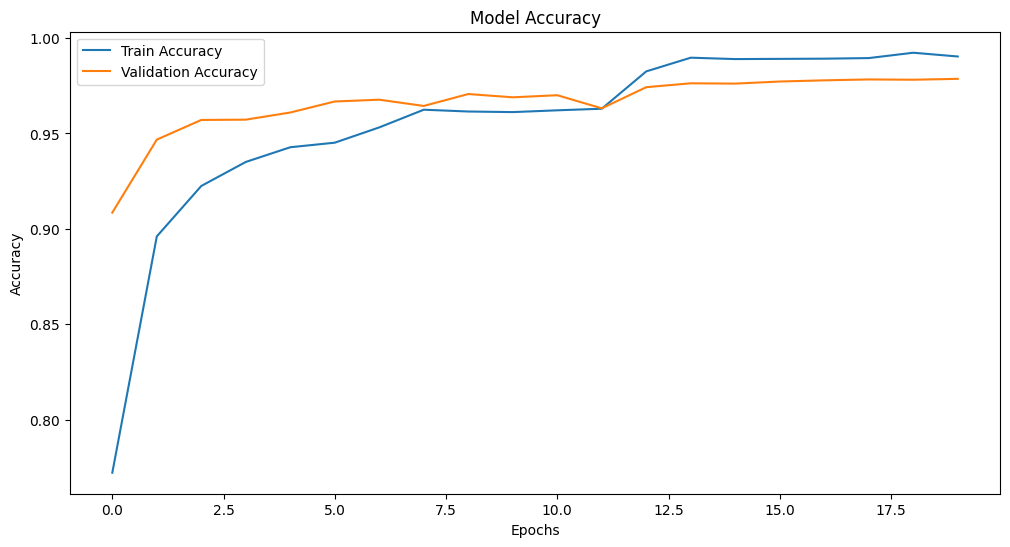

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


201/201 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step


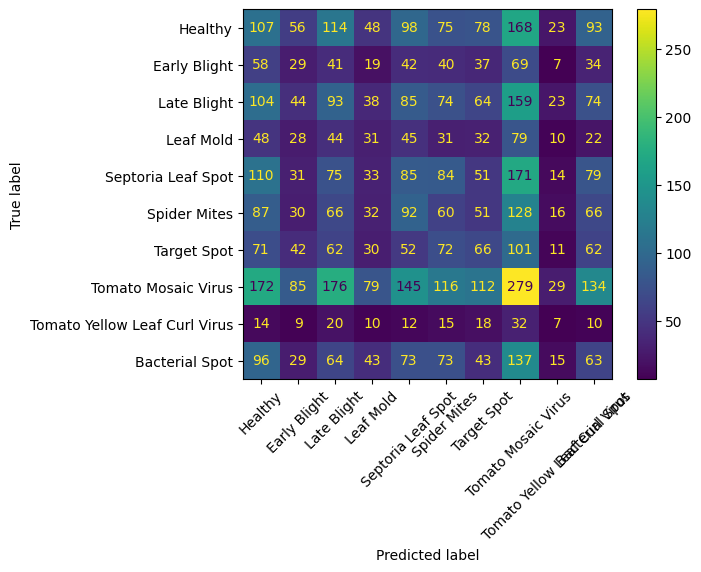

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on validation data
val_predictions = np.argmax(model.predict(val_data), axis=1)
val_labels = np.concatenate([y for x, y in val_data], axis=0)
# Define class names explicitly if not available
class_names = [
    "Bacterial Spot",
    "Early Blight",
    "Late Blight",
    "Leaf Mold",
    "Septoria Leaf Spot",
    "Spider Mites",
    "Target Spot",
    "Tomato Yellow Leaf Curl Virus",
    "Tomato Mosaic Virus",
    "Healthy"
]


# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.show()


In [ ]:
# Unfreeze top layers of ResNet50
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but last 10 layers
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 86s 238ms/step - accuracy: 0.9695 - loss: 0.0881 - val_accuracy: 0.9741 - val_loss: 0.0957 - learning_rate: 1.0000e-05
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - accuracy: 0.9892 - loss: 0.0336 - val_accuracy: 0.9760 - val_loss: 0.0909 - learning_rate: 1.0000e-05
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.9911 - loss: 0.0270 - val_accuracy: 0.9772 - val_loss: 0.0877 - learning_rate: 1.0000e-05
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.9922 - loss: 0.0213 - val_accuracy: 0.9774 - val_loss: 0.0883 - learning_rate: 1.0000e-05
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 55s 183ms/step - accuracy: 0.9946 - loss: 0.0179 - val_accuracy: 0.9775 - val_loss: 0.0880 - learning_rate: 1.0000e-05


In [ ]:
!pip install opencv-python-headless tensorflow matplotlib rembg scikit-image
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from rembg import remove
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or invalid format!")

    # Convert to RGB (from BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Remove background
    image_no_bg = remove(image)

    # Convert to grayscale and threshold to isolate objects
    gray = cv2.cvtColor(image_no_bg, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    # Label connected regions
    labeled_image = label(binary)
    regions = regionprops(labeled_image)

    # Find the largest region (assumes it's the leaf)
    largest_region = max(regions, key=lambda x: x.area, default=None)

    if largest_region:
        # Crop to the largest region
        min_row, min_col, max_row, max_col = largest_region.bbox
        image_cropped = image[min_row:max_row, min_col:max_col]
    else:
        raise ValueError("No leaf detected in the image!")

    # Resize the cropped image to match the input shape of the model
    image_resized = cv2.resize(image_cropped, (224, 224))

    # Preprocess for ResNet50
    image_preprocessed = preprocess_input(image_resized)
    image_preprocessed = np.expand_dims(image_preprocessed, axis=0)

    return image_preprocessed, image_resized


In [ ]:

def predict_disease(image_path):
    try:
        # Preprocess the image
        preprocessed_image, display_image = preprocess_image(image_path)

        # Predict using the model
        predictions = model.predict(preprocessed_image)
        predicted_class = np.argmax(predictions, axis=1)[0]
        confidence = predictions[0][predicted_class]

        # Display the processed image
        plt.imshow(display_image)
        plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
        plt.axis('off')
        plt.show()

        return class_names[predicted_class], confidence

    except ValueError as e:
        print(f"Error: {e}")


In [ ]:
class_names = [
    "Bacterial Spot",
    "Early Blight",
    "Late Blight",
    "Leaf Mold",
    "Septoria Leaf Spot",
    "Spider Mites",
    "Target Spot",
    "Tomato Yellow Leaf Curl Virus",
    "Tomato Mosaic Virus",
    "Healthy"
]

Saving b6176eb3-1480-4d4e-b1d7-2d23e3e825c3___JR_Sept.L.S 8384.JPG to b6176eb3-1480-4d4e-b1d7-2d23e3e825c3___JR_Sept.L.S 8384.JPG
Saving b06560a7-6ad1-438a-8ea2-badfe58a5f1e___Matt.S_CG 1250.JPG to b06560a7-6ad1-438a-8ea2-badfe58a5f1e___Matt.S_CG 1250.JPG
Saving b6905f0b-a167-4b6c-a72b-3c6c187d8032___Matt.S_CG 6046.JPG to b6905f0b-a167-4b6c-a72b-3c6c187d8032___Matt.S_CG 6046.JPG
Saving b8761d9f-9f66-4e83-a712-507e05010403___Keller.St_CG 1806.JPG to b8761d9f-9f66-4e83-a712-507e05010403___Keller.St_CG 1806.JPG
Processing image: b6176eb3-1480-4d4e-b1d7-2d23e3e825c3___JR_Sept.L.S 8384.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


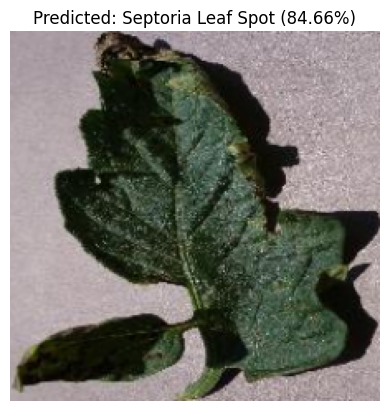

Prediction: Septoria Leaf Spot (84.66%)
Processing image: b06560a7-6ad1-438a-8ea2-badfe58a5f1e___Matt.S_CG 1250.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


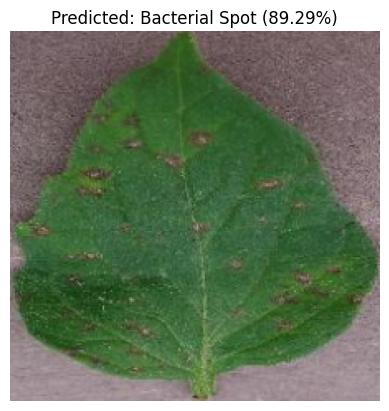

Prediction: Bacterial Spot (89.29%)
Processing image: b6905f0b-a167-4b6c-a72b-3c6c187d8032___Matt.S_CG 6046.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


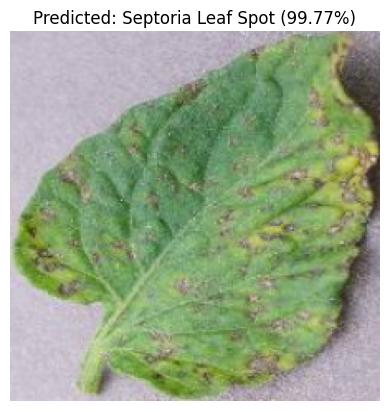

Prediction: Septoria Leaf Spot (99.77%)
Processing image: b8761d9f-9f66-4e83-a712-507e05010403___Keller.St_CG 1806.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


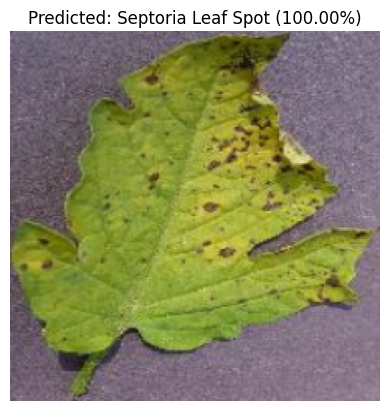

Prediction: Septoria Leaf Spot (100.00%)


In [ ]:
from google.colab import files

# Upload image
uploaded = files.upload()

# Predict disease for the uploaded image
for file_name in uploaded.keys():
    print(f"Processing image: {file_name}")
    predicted_class, confidence = predict_disease(file_name)
    print(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Directory to save the model
save_dir = '/content/drive/My Drive/models'
os.makedirs(save_dir, exist_ok=True)

# Save the entire model
model.save(os.path.join(save_dir, 'newresnet.keras'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
import os
# Mount Google Drive
drive.mount('/content/drive')

# Path to the saved model
save_dir = '/content/drive/My Drive/models'
model = load_model(os.path.join(save_dir, 'newresnet.keras'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
